In [2]:
!pip install --upgrade fANOVA
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00:00:0100:01m
Using cached graphviz-0.21-py3-none-any.whl (47 kB)

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import sqlite3
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ana_utils import convert_listlike_cols, db_path, font_size, font_size_large, df_to_latex_table
import json
#from fanova import fANOVA
from pathlib import Path
from ConfigSpace import (
    Categorical, 
    Float, 
    Integer, 
    Constant, 
    UniformFloatHyperparameter, 
    UniformIntegerHyperparameter, 
    CategoricalHyperparameter,
    Configuration
)
import numpy as np
import ConfigSpace 
from catboost import CatBoostRegressor
from tqdm.auto import tqdm

In [2]:
METRIC = "r2_score"

# Copy Pasted from utils --> Keep UpToDate
def get_configspace(path: str | Path) -> ConfigSpace.ConfigurationSpace:
    """Load a ConfigSpace from a given file path."""
    cs = ConfigSpace.ConfigurationSpace.from_yaml(path)

    # Preprocessing Search Space
    # cs.add(Constant("enable_numeric_features", value=True))
    cs.add(Categorical("enable_categorical_features", [True, False],default=True))
    cs.add(Categorical("enable_datetime_features", [True, False],default=True))
    cs.add(Categorical("enable_text_special_features", [True, False],default=True))
    cs.add(Categorical("enable_text_ngram_features", [True, False],default=True))
    cs.add(Categorical("enable_raw_text_features", [True, False],default=False))
    cs.add(Categorical("allow_nans", [True, False],default=False))
    cs.add(Categorical("prepro_analyzer", ["word", "char", "char_wb"], default="word"))
    cs.add(Float("prepro_min_df", (0.005, 1.0), log=True, default=0.2))
    cs.add(Integer("prepro_max_features", (5, 20000), log=True, default=10000))

    return cs

class CatBoost():
    def __init__(self, **kwargs):
        train_dir = Path("./cache/catboost/cat")
        train_dir.mkdir(exist_ok=True, parents=True)
        self.model = CatBoostRegressor(verbose=0, train_dir=train_dir, allow_writing_files=False, **kwargs) # This thing blocks itself if trained in parallel
    
    def train(self, X, y):
        cat_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()
        self.model.fit(X=X, y=y, cat_features=cat_cols)
    
    def predict(self, X):
        return self.model.predict(X)

In [3]:
conn = sqlite3.connect(db_path)
df = pd.read_sql(f"SELECT trials.model as model, trials.config as config, trials.{METRIC} as metric, results.data_config_hash as data_config_hash, results.data_id as data_id, fold FROM trials inner join results on results.search_id = trials.search_id", conn)
df_datasets = pd.read_sql("SELECT * FROM datasets", conn)
conn.close()
df.head(10)

,model,config,metric,data_config_hash,data_id,fold
0,AdaBoost,"{""learning_rate"": 0.3213869333267212, ""prepro_...",-37.583585,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
1,AdaBoost,"{""learning_rate"": 1.4869170188903809, ""prepro_...",-0.162924,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
2,AdaBoost,"{""learning_rate"": 0.5998979806900024, ""prepro_...",-218.126485,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
3,AdaBoost,"{""learning_rate"": 0.8062264919281006, ""prepro_...",-0.082301,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
4,AdaBoost,"{""learning_rate"": 1.1691440343856812, ""prepro_...",-252.362393,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
5,AdaBoost,"{""learning_rate"": 0.022289639338850975, ""prepr...",-0.063362,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
6,AdaBoost,"{""learning_rate"": 0.15547768771648407, ""prepro...",-39.743013,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
7,AdaBoost,"{""learning_rate"": 1.7614549398422241, ""prepro_...",-4.165825,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
8,AdaBoost,"{""learning_rate"": 1.0357438325881958, ""prepro_...",-0.145420,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9
9,AdaBoost,"{""learning_rate"": 1.3703616857528687, ""prepro_...",-524.211452,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,30,9


In [4]:
import itertools as it
import logging
from collections import OrderedDict

import ConfigSpace
import numpy as np
import pandas as pd
import pyrfr.regression as reg
import pyrfr.util
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformFloatHyperparameter, \
    NumericalHyperparameter, Constant, OrdinalHyperparameter


class fANOVA(object):
    def __init__(self, X, Y, config_space=None,
                 n_trees=16, seed=None, bootstrapping=True,
                 points_per_tree=None, max_features=None,
                 min_samples_split=0, min_samples_leaf=0,
                 max_depth=64, cutoffs=(-np.inf, np.inf)):
    
        pcs = [(np.nan, np.nan)] * X.shape[1]
    
        # Convert pd.DataFrame to np.array
        if isinstance(X, pd.DataFrame):
            print("Detected pandas dataframes, converting to floats...")
            if config_space is not None:
                # Check if column names match parameter names
                bad_input = set(X.columns) - set(config_space.get_hyperparameter_names())
                if len(bad_input) != 0:
                    raise ValueError("Could not identify parameters %s from pandas dataframes" % str(bad_input))
                # Reorder dataframe if necessary
                X = X[config_space.get_hyperparameter_names()]
            X = X.to_numpy()
        elif config_space is not None:
            # There is a config_space but no way to check if the np.array'ed data in X is in the correct order...
            print("Note that fANOVA expects data to be ordered like the return of ConfigSpace's "
                                "'get_hyperparameters'-method. We recommend to use labeled pandas dataframes to "
                                "avoid any problems.")
    
        # if no ConfigSpace is specified, let's build one with all continuous variables
        if config_space is None:
            # if no info is given, use min and max values of each variable as bounds
            config_space = ConfigSpace.ConfigurationSpace()
            for i, (mn, mx) in enumerate(zip(np.min(X, axis=0), np.max(X, axis=0))):
                config_space.add_hyperparameter(UniformFloatHyperparameter("x_%03i" % i, mn, mx))
    
        self.percentiles = np.percentile(Y, range(0, 100))
        self.cs = config_space
        self.cs_params = self.cs.get_hyperparameters()
        self.n_dims = len(self.cs_params)
        self.n_trees = n_trees
        self._dict = False
    
        # at this point we have a valid ConfigSpace object
        # check if param number is correct etc:
        if X.shape[1] != len(self.cs_params):
            raise RuntimeError('Number of parameters in ConfigSpace object does not match input X')
        for i in range(len(self.cs_params)):
            if isinstance(self.cs_params[i], NumericalHyperparameter):
                if (np.max(X[:, i]) > self.cs_params[i].upper) or \
                        (np.min(X[:, i]) < self.cs_params[i].lower):
                    print(self.cs_params[i], np.max(X[:, i]), np.min(X[:, i]))
                    raise RuntimeError('Some sample values from X are not in the given interval')
            elif isinstance(self.cs_params[i], CategoricalHyperparameter):
                unique_vals = set(X[:, i])
                if len(unique_vals) > len(self.cs_params[i].choices):
                    raise RuntimeError("There are some categoricals missing in the ConfigSpace specification for "
                                       "hyperparameter %s:" % self.cs_params[i].name)
            elif isinstance(self.cs_params[i], OrdinalHyperparameter):
                unique_vals = set(X[:, i])
                if len(unique_vals) > len(self.cs_params[i].sequence):
                    raise RuntimeError("There are some sequence-options missing in the ConfigSpace specification for "
                                       "hyperparameter %s:" % self.cs_params[i].name)
            elif isinstance(self.cs_params[i], Constant):
                # oddly, unparameterizedhyperparameter and constant are not supported. 
                # raise TypeError('Unsupported Hyperparameter: %s' % type(self.cs_params[i]))
                pass
                # unique_vals = set(X[:, i])
                # if len(unique_vals) > 1:
                #     raise RuntimeError('Got multiple values for Unparameterized (Constant) hyperparameter')
            else:
                raise TypeError('Unsupported Hyperparameter: %s' % type(self.cs_params[i]))
    
        # initialize all types as 0
        types = np.zeros(len(self.cs_params), dtype=np.uint)
        # retrieve the types and the bounds from the ConfigSpace 
        # TODO: Test if that actually works
        for i, hp in enumerate(self.cs_params):
            if isinstance(hp, CategoricalHyperparameter):
                types[i] = len(hp.choices)
                pcs[i] = (len(hp.choices), np.nan)
            elif isinstance(hp, OrdinalHyperparameter):
                types[i] = len(hp.sequence)
                pcs[i] = (len(hp.sequence), np.nan)
            elif isinstance(self.cs_params[i], NumericalHyperparameter):
                pcs[i] = (hp.lower, hp.upper)
            elif isinstance(self.cs_params[i], Constant):
                types[i] = 1
                pcs[i] = (1, np.nan)
            else:
                raise TypeError('Unsupported Hyperparameter: %s' % type(hp))
    
        # set forest options
        forest = reg.fanova_forest()
        forest.options.num_trees = n_trees
        forest.options.do_bootstrapping = bootstrapping
        forest.options.num_data_points_per_tree = X.shape[0] if points_per_tree is None else points_per_tree
        forest.options.tree_opts.max_features = (X.shape[1] * 7) // 10 if max_features is None else max_features
    
        forest.options.tree_opts.min_samples_to_split = min_samples_split
        forest.options.tree_opts.min_samples_in_leaf = min_samples_leaf
        forest.options.tree_opts.max_depth = max_depth
        forest.options.tree_opts.epsilon_purity = 1e-8
    
        # create data container and provide all the necessary information
        if seed is None:
            rng = reg.default_random_engine(np.random.randint(2 ** 31 - 1))
        else:
            rng = reg.default_random_engine(seed)
        data = reg.default_data_container(X.shape[1])
    
        for i, (mn, mx) in enumerate(pcs):
            if np.isnan(mx):
                data.set_type_of_feature(i, mn)
            else:
                data.set_bounds_of_feature(i, mn, mx)
    
        for i in range(len(Y)):
            #print("process datapoint: %s", str(X[i].tolist()))
            config = {key.name: val for key, val in zip(self.cs_params, X[i])}
            config = Configuration(cs, values=config)
            data.add_data_point(config.get_array().tolist(), Y[i])
    
        forest.fit(data, rng)
    
        self.the_forest = forest
    
        # initialize a dictionary with parameter dims
        self.variance_dict = dict()
    
        # getting split values
        forest_split_values = self.the_forest.all_split_values()
    
        # all midpoints and interval sizes treewise for the whole forest
        self.all_midpoints = []
        self.all_sizes = []
    
        # compute midpoints and interval sizes for variables in each tree
        for tree_split_values in forest_split_values:
            sizes = []
            midpoints = []
            for i, split_vals in enumerate(tree_split_values):
                if np.isnan(pcs[i][1]):  # categorical parameter
                    # check if the tree actually splits on this parameter
                    if len(split_vals) > 0:
                        midpoints.append(split_vals)
                        sizes.append(np.ones(len(split_vals)))
                    # if not, simply append 0 as the value with the number of categories as the size, that way this
                    # parameter will get 0 importance from this tree.
                    else:
                        midpoints.append((0,))
                        sizes.append((pcs[i][0],))
                else:
                    # add bounds to split values
                    sv = np.array([pcs[i][0]] + list(split_vals) + [pcs[i][1]])
                    # compute midpoints and sizes
                    midpoints.append((1 / 2) * (sv[1:] + sv[:-1]))
                    sizes.append(sv[1:] - sv[:-1])
    
            self.all_midpoints.append(midpoints)
            self.all_sizes.append(sizes)
    
        # capital V in the paper
        self.trees_total_variances = []
        # dict of lists where the keys are tuples of the dimensions
        # and the value list contains \hat{f}_U for the individual trees
        # reset all the variance fractions computed
        self.trees_variance_fractions = {}
        self.V_U_total = {}
        self.V_U_individual = {}
    
        self.cutoffs = cutoffs
        print(cutoffs)
        #self.set_cutoffs(cutoffs)

    def set_cutoffs(self, cutoffs=(-np.inf, np.inf), quantile=None):
        """
        Setting the cutoffs to constrain the input space
        
        To properly do things like 'improvement over default' the
        fANOVA now supports cutoffs on the y values. These will exclude
        parts of the parameters space where the prediction is not within
        the provided cutoffs. This is is specialization of 
        "Generalized Functional ANOVA Diagnostics for High Dimensional
        Functions of Dependent Variables" by Hooker.
        """
        if not (quantile is None):
            percentile1 = self.percentiles[quantile[0]]
            percentile2 = self.percentiles[quantile[1]]
            self.the_forest.set_cutoffs(percentile1, percentile2)
        else:

            self.cutoffs = cutoffs
            self.the_forest.set_cutoffs(cutoffs[0], cutoffs[1])

        # reset all the variance fractions computed
        self.trees_variance_fractions = {}
        self.V_U_total = {}
        self.V_U_individual = {}

        # recompute the trees' total variance
        self.trees_total_variance = self.the_forest.get_trees_total_variances()

    def __compute_marginals(self, dimensions):
        """
        Returns the marginal of selected parameters
                
        Parameters
        ----------
        dimensions: tuple
            Contains the indices of ConfigSpace for the selected parameters (starts with 0)
        """
        dimensions = tuple(dimensions)

        # check if values has been previously computed
        if dimensions in self.V_U_individual:
            return

        # otherwise make sure all lower order marginals have been
        # computed, if not compute them
        for k in range(1, len(dimensions)):
            for sub_dims in it.combinations(dimensions, k):
                if sub_dims not in self.V_U_total:
                    self.__compute_marginals(sub_dims)

        # now all lower order terms have been computed
        self.V_U_individual[dimensions] = []
        self.V_U_total[dimensions] = []
        for tree_idx in range(len(self.all_midpoints)):
            # collect all the midpoints and corresponding sizes for that tree
            midpoints = [self.all_midpoints[tree_idx][dim] for dim in dimensions]
            sizes = [self.all_sizes[tree_idx][dim] for dim in dimensions]
            stat = pyrfr.util.weighted_running_stats()

            prod_midpoints = it.product(*midpoints)
            prod_sizes = it.product(*sizes)

            sample = np.full(self.n_dims, np.nan, dtype=float)

            # make prediction for all midpoints and weigh them by the corresponding size
            for i, (m, s) in enumerate(zip(prod_midpoints, prod_sizes)):
                sample[list(dimensions)] = list(m)
                ls = self.the_forest.marginal_prediction_stat_of_tree(tree_idx, sample.tolist())
                # self.logger.debug("%s, %s", (sample, ls.mean()))
                if not np.isnan(ls.mean()):
                    stat.push(ls.mean(), np.prod(np.array(s)) * ls.sum_of_weights())

            # line 10 in algorithm 2
            # note that V_U^2 can be computed by var(\hat a)^2 - \sum_{subU} var(f_subU)^2
            # which is why, \hat{f} is never computed in the code, but
            # appears in the pseudocode
            V_U_total = np.nan
            V_U_individual = np.nan

            if stat.sum_of_weights() > 0:
                V_U_total = stat.variance_population()
                V_U_individual = stat.variance_population()
                for k in range(1, len(dimensions)):
                    for sub_dims in it.combinations(dimensions, k):
                        V_U_individual -= self.V_U_individual[sub_dims][tree_idx]
                V_U_individual = np.clip(V_U_individual, 0, np.inf)

            self.V_U_individual[dimensions].append(V_U_individual)
            self.V_U_total[dimensions].append(V_U_total)

    def quantify_importance(self, dims):
        if type(dims[0]) == str:
            idx = []
            for i, param in enumerate(dims):
                idx.append(self.cs.get_idx_by_hyperparameter_name(param))
            dimensions = idx
        # make sure that all the V_U values are computed for each tree
        else:
            dimensions = dims

        self.__compute_marginals(dimensions)

        importance_dict = {}

        for k in range(1, len(dimensions) + 1):
            for sub_dims in it.combinations(dimensions, k):
                if type(dims[0]) == str:
                    dim_names = []
                    for j, dim in enumerate(sub_dims):
                        dim_names.append(self.cs.get_hyperparameter_by_idx(dim))
                    dim_names = tuple(dim_names)
                    importance_dict[dim_names] = {}
                else:
                    importance_dict[sub_dims] = {}
                # clean here to catch zero variance in a trees
                non_zero_idx = np.nonzero([self.trees_total_variance[t] for t in range(self.n_trees)])
                if len(non_zero_idx[0]) == 0:
                    raise RuntimeError('Encountered zero total variance in all trees.')

                fractions_total = np.array([self.V_U_total[sub_dims][t] / self.trees_total_variance[t]
                                            for t in non_zero_idx[0]])
                fractions_individual = np.array([self.V_U_individual[sub_dims][t] / self.trees_total_variance[t]
                                                 for t in non_zero_idx[0]])

                if type(dims[0]) == str:
                    importance_dict[dim_names]['individual importance'] = np.mean(fractions_individual)
                    importance_dict[dim_names]['total importance'] = np.mean(fractions_total)
                    importance_dict[dim_names]['individual std'] = np.std(fractions_individual)
                    importance_dict[dim_names]['total std'] = np.std(fractions_total)
                else:
                    importance_dict[sub_dims]['individual importance'] = np.mean(fractions_individual)
                    importance_dict[sub_dims]['total importance'] = np.mean(fractions_total)
                    importance_dict[sub_dims]['individual std'] = np.std(fractions_individual)
                    importance_dict[sub_dims]['total std'] = np.std(fractions_total)

        return importance_dict

    def marginal_mean_variance_for_values(self, dimlist, values_to_predict):
        """
        Returns the marginal of selected parameters for specific values
                
        Parameters
        ----------
        dimlist: list
                Contains the indices of ConfigSpace for the selected parameters 
                (starts with 0) 
        values_to_predict: list
                Contains the values to be predicted
              
        Returns
        -------
        tuple 
            marginal mean prediction and corresponding variance estimate
        """
        sample = np.full(self.n_dims, np.nan, dtype=float)
        for i in range(len(dimlist)):
            sample[dimlist[i]] = values_to_predict[i]

        return self.the_forest.marginal_mean_variance_prediction(sample)

    def get_most_important_pairwise_marginals(self, params=None, n=10):
        """
        Returns the n most important pairwise marginals from the whole ConfigSpace
            
        Parameters
        ----------
        params: list of strings or ints
            If specified, limit analysis to those parameters. If ints, interpreting as indices from ConfigurationSpace
        n: int
             The number of most relevant pairwise marginals that will be returned
          
        Returns
        -------
        list: 
             Contains the n most important pairwise marginals
        """
        self.tot_imp_dict = OrderedDict()
        pairwise_marginals = []
        if params is None:
            dimensions = range(self.n_dims)
        else:
            if type(params[0]) == str:
                idx = []
                for i, param in enumerate(params):
                    idx.append(self.cs.get_idx_by_hyperparameter_name(param))
                dimensions = idx

            else:
                dimensions = params
        # pairs = it.combinations(dimensions,2)
        pairs = [x for x in it.combinations(dimensions, 2)]
        if params:
            n = len(list(pairs))
        for combi in pairs:
            pairwise_marginal_performance = self.quantify_importance(combi)
            tot_imp = pairwise_marginal_performance[combi]['individual importance']
            combi_names = [self.cs_params[combi[0]].name, self.cs_params[combi[1]].name]
            pairwise_marginals.append((tot_imp, combi_names[0], combi_names[1]))

        pairwise_marginal_performance = sorted(pairwise_marginals, reverse=True)

        for marginal, p1, p2 in pairwise_marginal_performance[:n]:
            self.tot_imp_dict[(p1, p2)] = marginal
        self._dict = True

        return self.tot_imp_dict

    def get_triple_marginals(self, params=None):
        """
        Returns the n most important pairwise marginals from the whole ConfigSpace
            
        Parameters
        ----------
        params: list
             The parameters
          
        Returns
        -------
        list: 
             Contains most important triple marginals
        """
        self.tot_imp_dict = OrderedDict()
        triple_marginals = []
        if len(params) < 3:
            raise RuntimeError(
                'Number of parameters have to be greater than %i. At least 3 parameters needed' % len(params))
        if type(params[0]) == str:
            idx = []
            for i, param in enumerate(params):
                idx.append(self.cs.get_idx_by_hyperparameter_name(param))
            dimensions = idx

        else:
            dimensions = params

        triplets = [x for x in it.combinations(dimensions, 3)]
        for combi in triplets:
            triple_marginal_performance = self.quantify_importance(combi)
            tot_imp = triple_marginal_performance[combi]['individual importance']
            combi_names = [self.cs_params[combi[0]].name, self.cs_params[combi[1]].name, self.cs_params[combi[2]].name]
            triple_marginals.append((tot_imp, combi_names[0], combi_names[1], combi_names[2]))

        triple_marginal_performance = sorted(triple_marginals, reverse=True)
        if params:
            triple_marginal_performance = triple_marginal_performance[:len(list(triplets))]

        for marginal, p1, p2, p3 in triple_marginal_performance:
            self.tot_imp_dict[(p1, p2, p3)] = marginal

        return self.tot_imp_dict

In [5]:
# TODO Separate Models
# TODO Separate DS
# TODO Separate Folds
model_groups = df.groupby(by=["model"])
results = {}
for model, model_df in tqdm(model_groups):
    print(model)
    params = pd.json_normalize(model_df["config"].map(json.loads))
    params.index = model_df.index 
    model_df = model_df.join(params)
    model_df = model_df.drop(["config", "model"], axis=1)

    cs_path = Path.cwd().parent / f"configs/search_spaces/{model[0]}.yml"
    cs = get_configspace(cs_path)
    hp_names = [hp.name for hp in list(cs.get_hyperparameters())]

    # # Make Features usable for ML
    # bool_cols = model_df.select_dtypes(include="bool").columns
    # model_df[bool_cols] = model_df[bool_cols].astype(int)
    # non_numeric = model_df.columns[model_df.dtypes == "object"]
    # for col in non_numeric:
    #     model_df[col] = model_df[col].astype("category").cat.codes
    
    dataset_groups = model_df.groupby(by=["data_config_hash", "data_id", "fold"])
    feature_importances = []
    for (data_hash, data_id, fold), fold_df in tqdm(dataset_groups):
        features = fold_df[hp_names]
        # features_ = features.apply(lambda x: Configuration(cs, values=x.to_dict()).get_dictionary(), axis=1)
        # features = pd.DataFrame(features_.tolist(), index=features.index, columns=hp_names)
        #features = features.reset_index(drop=True)
        metric = fold_df["metric"]
        cb = CatBoost()
        try: 
            cb.train(features, metric)
        except:
            continue
        feature_importance = cb.model.get_feature_importance()
        #print(feature_importance)
        feature_importances.append(feature_importance)

        # try: # TODO Remove Catch Later 
        #     f = fANOVA(X=features, Y=metric.astype('float64').to_numpy(), config_space=cs) #, cutoffs=(1, 1000000))
        # except:
        #     pass
        #print("!!!!!: ", f.quantify_importance((0, )))
    feature_importances = pd.DataFrame(feature_importances, columns=hp_names)
    importances = dict(feature_importances.mean())
    variances = dict(feature_importances.var())
    print(importances)
    results[model[0]] = {feat: [importances[feat], variances[feat]] for feat in importances.keys()}
        
results

  0%|          | 0/26 [00:00<?, ?it/s]

('AdaBoost',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.29491302860035723, 'enable_categorical_features': 5.487983335751074, 'enable_datetime_features': 0.31621487935538306, 'enable_raw_text_features': 0.2989545893641427, 'enable_text_ngram_features': 0.2569653372348472, 'enable_text_special_features': 0.3817451898623313, 'estimator': 57.01099678343577, 'learning_rate': 16.868240154894607, 'loss': 13.027623721708315, 'prepro_analyzer': 1.4532070915361732, 'prepro_max_features': 2.3265004419576223, 'prepro_min_df': 2.2766554462993747}
('Bagging',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.8747172713399791, 'bootstrap_features': 3.684556884752371, 'enable_categorical_features': 5.117844304328865, 'enable_datetime_features': 0.7343668128075929, 'enable_raw_text_features': 0.5738091406805886, 'enable_text_ngram_features': 0.5476354874677882, 'enable_text_special_features': 0.7005996686515649, 'estimator': 26.78638725770883, 'max_features': 45.39230806836999, 'max_samples': 5.094482724781674, 'prepro_analyzer': 2.6206093645608117, 'prepro_max_features': 4.173687702054214, 'prepro_min_df': 3.6989953124957244}
('BayesianRidge',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 1.5315028829083164, 'alpha_1': 0.6924995810512675, 'alpha_2': 0.9631335397404324, 'alpha_init': 2.376444177009563, 'enable_categorical_features': 30.39807360730392, 'enable_datetime_features': 0.14676703269357308, 'enable_raw_text_features': 0.16516811881719182, 'enable_text_ngram_features': 0.22954816691486077, 'enable_text_special_features': 0.17505154140928453, 'lambda_1': 32.544540256708004, 'lambda_2': 27.819827156287047, 'lambda_init': 0.8103125246990924, 'prepro_analyzer': 0.6897002582508219, 'prepro_max_features': 0.6244673111092879, 'prepro_min_df': 0.8329638450973378}
('CatBoost',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.2932994177671648, 'depth': 4.414038858554538, 'enable_categorical_features': 8.795326013517709, 'enable_datetime_features': 0.8904591307923193, 'enable_raw_text_features': 0.36835545505573863, 'enable_text_ngram_features': 0.5113481828247252, 'enable_text_special_features': 0.3947837366678472, 'l2_leaf_reg': 3.8633236940942766, 'learning_rate': 26.366622832787485, 'loss_function': 45.41935708465691, 'prepro_analyzer': 2.655326978316435, 'prepro_max_features': 2.0749736452073564, 'prepro_min_df': 3.952784969757503}
('DecisionTree',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 2.9673948833774495, 'criterion': 11.06835008028172, 'enable_categorical_features': 12.283764350942425, 'enable_datetime_features': 1.0531900952650506, 'enable_raw_text_features': 1.2115266560810234, 'enable_text_ngram_features': 1.0449731669946383, 'enable_text_special_features': 1.1707084496026592, 'max_features': 24.399902008854173, 'min_samples_split': 19.366391190342387, 'prepro_analyzer': 4.935027301843755, 'prepro_max_features': 7.17144506051127, 'prepro_min_df': 6.606101581220703, 'splitter': 6.721225174682751}
('Dummy',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.0034650277471948306, 'enable_categorical_features': 0.001012643128273148, 'enable_datetime_features': 0.0031148490590173386, 'enable_raw_text_features': 0.0012981060558338703, 'enable_text_ngram_features': 0.002307309113388299, 'enable_text_special_features': 0.003874591356240573, 'prepro_analyzer': 0.25301275996670725, 'prepro_max_features': 0.17277342063556791, 'prepro_min_df': 0.16413932118267743, 'strategy': 99.3950019717551}
('ElasticNet',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.1981424484471907, 'alpha': 31.99417078279945, 'enable_categorical_features': 1.9357963053831502, 'enable_datetime_features': 0.05378170036770626, 'enable_raw_text_features': 0.06249446079586893, 'enable_text_ngram_features': 0.1665494115620865, 'enable_text_special_features': 0.16200424823018178, 'fit_intercept': 31.346580674171854, 'l1_ratio': 12.385293756955473, 'positive': 18.10910421828382, 'prepro_analyzer': 0.38581240250858007, 'prepro_max_features': 0.7624035072018072, 'prepro_min_df': 0.5765879332195786, 'selection': 1.8612781500732503}
('ExtraTrees',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/31 [00:00<?, ?it/s]

{'allow_nans': 0.4101974557651801, 'criterion': 7.916380935642616, 'enable_categorical_features': 12.971417700911505, 'enable_datetime_features': 0.4725817777195855, 'enable_raw_text_features': 0.4438213366247235, 'enable_text_ngram_features': 0.7478984128847834, 'enable_text_special_features': 0.49989008866070256, 'max_features': 42.151316071869374, 'min_samples_split': 27.457438009831872, 'prepro_analyzer': 2.1289988864577283, 'prepro_max_features': 2.3270240655496934, 'prepro_min_df': 2.4730352580822483}
('GaussianProcess',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/31 [00:00<?, ?it/s]

{'allow_nans': 0.27560187027412647, 'enable_categorical_features': 1.636160370399745, 'enable_datetime_features': 0.29281508017490687, 'enable_raw_text_features': 0.33708497049369507, 'enable_text_ngram_features': 0.16722027942394177, 'enable_text_special_features': 0.3289870215860377, 'kernel': 44.37259196999012, 'n_restarts_optimizer': 2.3098128220743495, 'normalize_y': 43.718406441305945, 'prepro_analyzer': 1.5218903779881958, 'prepro_max_features': 2.4567026923196003, 'prepro_min_df': 2.5827261039693155}
('GradientBoosting',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.2961535883409248, 'criterion': 0.46747818916203454, 'enable_categorical_features': 9.689649916357544, 'enable_datetime_features': 0.33092120242676626, 'enable_raw_text_features': 0.5783358776067972, 'enable_text_ngram_features': 0.3859940422343607, 'enable_text_special_features': 0.4646554485347473, 'learning_rate': 24.22592795105719, 'loss': 39.86033114087923, 'max_depth': 11.177400161465542, 'min_samples_split': 2.092825419658721, 'prepro_analyzer': 1.9020376733305073, 'prepro_max_features': 2.8546522688000238, 'prepro_min_df': 2.6454909822220145, 'subsample': 3.02814613792359}
('Huber',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 2.0767840597648464, 'alpha': 5.887742225104878, 'enable_categorical_features': 10.242620000925813, 'enable_datetime_features': 0.6624583252701444, 'enable_raw_text_features': 0.6041713881763789, 'enable_text_ngram_features': 0.646089345033599, 'enable_text_special_features': 0.5461706591085853, 'epsilon': 25.856836195904673, 'fit_intercept': 26.592855534725043, 'max_iter': 14.557374177010756, 'prepro_analyzer': 3.136970781993672, 'prepro_max_features': 4.706468478277093, 'prepro_min_df': 4.483458828704524}
('KNN',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.1279991678666478, 'enable_categorical_features': 9.279040252801325, 'enable_datetime_features': 0.18376974086958658, 'enable_raw_text_features': 0.15178059251443132, 'enable_text_ngram_features': 0.17794934741358692, 'enable_text_special_features': 0.19960298393008252, 'n_neighbors': 48.49346639161788, 'p': 18.51300731810441, 'prepro_analyzer': 0.8879881366216135, 'prepro_max_features': 0.9825892937036763, 'prepro_min_df': 1.0710577170896098, 'weights': 19.931749057467155}
('LARS',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/34 [00:00<?, ?it/s]

{'allow_nans': 0.004315744711379921, 'enable_categorical_features': 14.122902579771388, 'enable_datetime_features': 0.005246771763901663, 'enable_raw_text_features': 0.00932555511191809, 'enable_text_ngram_features': 0.007977723926833125, 'enable_text_special_features': 0.006043100521172373, 'fit_intercept': 82.8195941419352, 'n_nonzero_coefs': 2.3062187583263927, 'prepro_analyzer': 0.2293110610886008, 'prepro_max_features': 0.2731080560613154, 'prepro_min_df': 0.21595650678188982}
('Lasso',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/34 [00:00<?, ?it/s]

{'allow_nans': 0.21877531878305018, 'alpha': 24.184933741167207, 'enable_categorical_features': 3.163352430545086, 'enable_datetime_features': 0.16911221297362844, 'enable_raw_text_features': 0.171196699465812, 'enable_text_ngram_features': 0.32001506377808475, 'enable_text_special_features': 0.18999773368152686, 'fit_intercept': 40.5622558222812, 'positive': 19.004662432598373, 'prepro_analyzer': 0.7657165708861281, 'prepro_max_features': 1.9062515175730672, 'prepro_min_df': 1.2794160237423333, 'selection': 2.5885178537480695, 'tol': 5.475796578776439}
('LassoLars',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/32 [00:00<?, ?it/s]

{'allow_nans': 0.044258323914488695, 'alpha': 25.06966683206692, 'enable_categorical_features': 3.3505042947418007, 'enable_datetime_features': 0.0659752509669708, 'enable_raw_text_features': 0.04640995568655654, 'enable_text_ngram_features': 0.012429139122058157, 'enable_text_special_features': 0.008855152435210512, 'fit_intercept': 37.36427323302251, 'positive': 32.678200593105935, 'prepro_analyzer': 0.5073742655366877, 'prepro_max_features': 0.47652049184303935, 'prepro_min_df': 0.37553246755782693}
('LightGBM',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.7444941874717999, 'enable_categorical_features': 0.933438787556936, 'enable_datetime_features': 0.8918795859523608, 'enable_raw_text_features': 0.6714777659871259, 'enable_text_ngram_features': 1.4195377139414862, 'enable_text_special_features': 2.9618449780919307, 'feature_fraction': 5.930935826166098, 'learning_rate': 23.341921044314635, 'min_data_in_leaf': 7.8696089332720245, 'num_leaves': 6.02513547936861, 'objective': 33.282354465880616, 'prepro_analyzer': 3.7985785503913796, 'prepro_max_features': 6.298503201838964, 'prepro_min_df': 5.830289479766019}
('M5',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/34 [00:00<?, ?it/s]

{'allow_nans': 1.2186278917704347, 'criterion': 7.68073920686017, 'enable_categorical_features': 13.479394975599357, 'enable_datetime_features': 0.393649237703134, 'enable_raw_text_features': 0.20865623793254437, 'enable_text_ngram_features': 0.2723363860782934, 'enable_text_special_features': 0.22134094770142343, 'leaf_model': 24.33793876325204, 'min_samples_leaf': 14.276445047863966, 'min_samples_split': 3.2222784929936448, 'prepro_analyzer': 1.9686469896959597, 'prepro_max_features': 2.1671074961249333, 'prepro_min_df': 2.0428026590563504, 'smoothing_constant': 7.893714325143589, 'use_pruning': 20.616321342224158}
('PartialLeastSquares',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/34 [00:00<?, ?it/s]

{'allow_nans': 0.8925262017857128, 'enable_categorical_features': 6.319761533234502, 'enable_datetime_features': 0.24779812041510005, 'enable_raw_text_features': 0.12062432643810285, 'enable_text_ngram_features': 0.21754939085473837, 'enable_text_special_features': 0.06790106487523398, 'n_components': 51.907064612397, 'prepro_analyzer': 1.2858696215066803, 'prepro_max_features': 0.6615532971358437, 'prepro_min_df': 0.6520517946750461, 'scale': 36.83047351706881, 'tol': 0.7968265196132406}
('PassiveAggressive',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'C': 14.115182952168263, 'allow_nans': 1.3475382324481975, 'enable_categorical_features': 1.8922899137003437, 'enable_datetime_features': 0.9868660671324979, 'enable_raw_text_features': 1.3612041376774735, 'enable_text_ngram_features': 1.2919556196373254, 'enable_text_special_features': 1.294720452777423, 'epsilon': 51.12912879591289, 'loss': 1.3644354210785918, 'prepro_analyzer': 4.9301866821787605, 'prepro_max_features': 9.422286781446994, 'prepro_min_df': 10.86420494384123}
('PolynomialRegression',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/6 [00:00<?, ?it/s]

{'allow_nans': 0.38977592459690147, 'degree': 53.48441213380253, 'enable_categorical_features': 10.892670413973311, 'enable_datetime_features': 0.4267548633189598, 'enable_raw_text_features': 0.1682644595113623, 'enable_text_ngram_features': 0.25249545834861326, 'enable_text_special_features': 0.34354915923192314, 'fit_intercept': 21.103426190709527, 'positive': 7.206557081939277, 'prepro_analyzer': 1.2558801957054584, 'prepro_max_features': 3.015361142108695, 'prepro_min_df': 1.4608529767534468}
('RandomForest',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/20 [00:00<?, ?it/s]

{'allow_nans': 0.7797499709714926, 'criterion': 11.622776447026107, 'enable_categorical_features': 1.5927091009041612, 'enable_datetime_features': 0.7725932084730884, 'enable_raw_text_features': 0.6339460990811634, 'enable_text_ngram_features': 0.6926613711888321, 'enable_text_special_features': 0.7252451438243163, 'max_features': 44.6625231553338, 'min_samples_split': 28.417741780472188, 'prepro_analyzer': 3.309791748094276, 'prepro_max_features': 3.632271243688981, 'prepro_min_df': 3.157990730941594}
('RidgeRegressor',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/34 [00:00<?, ?it/s]

{'allow_nans': 0.058921226200941784, 'alpha': 0.6449300489412506, 'enable_categorical_features': 2.844457169175699, 'enable_datetime_features': 0.056310414007739285, 'enable_raw_text_features': 0.03857132323200604, 'enable_text_ngram_features': 0.10662763391676333, 'enable_text_special_features': 0.02329234044438119, 'fit_intercept': 24.309032381280783, 'positive': 66.17554472014558, 'prepro_analyzer': 0.41335618142780056, 'prepro_max_features': 0.5467450752944369, 'prepro_min_df': 0.5684163645764917, 'tol': 4.2137951213561236}
('SGD',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/35 [00:00<?, ?it/s]

{'allow_nans': 0.7599994724100138, 'alpha': 7.310345031042905, 'enable_categorical_features': 0.9692993926550384, 'enable_datetime_features': 0.44015862696293745, 'enable_raw_text_features': 0.751785511742759, 'enable_text_ngram_features': 0.5836102090913524, 'enable_text_special_features': 0.5409954274994516, 'eta0': 13.772958319425063, 'l1_ratio': 4.390429844429428, 'learning_rate': 28.796768240967644, 'loss': 21.590563929942363, 'max_iter': 4.855306169916893, 'penalty': 3.12384654208613, 'prepro_analyzer': 2.7535088565678154, 'prepro_max_features': 5.6179039639546575, 'prepro_min_df': 3.7425204613055287}
('SupportVectorRegression',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/7 [00:00<?, ?it/s]

{'C': 25.594444658750398, 'allow_nans': 0.9917674492392228, 'degree': 8.929161519101667, 'enable_categorical_features': 0.659974844146792, 'enable_datetime_features': 0.8315553518070293, 'enable_raw_text_features': 0.5542116559506756, 'enable_text_ngram_features': 1.4221652651218095, 'enable_text_special_features': 0.23541593061159355, 'gamma': 3.3214593999159825, 'kernel': 44.07022789309237, 'prepro_analyzer': 4.410952797387256, 'prepro_max_features': 4.837290155553328, 'prepro_min_df': 4.141373079321869}
('Tweedie',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/29 [00:00<?, ?it/s]

{'allow_nans': 0.2329877295722557, 'alpha': 21.507194248308426, 'enable_categorical_features': 2.614683229490701, 'enable_datetime_features': 0.17620953051892518, 'enable_raw_text_features': 0.23646076166367816, 'enable_text_ngram_features': 0.4392967044404008, 'enable_text_special_features': 0.08960691434370671, 'fit_intercept': 35.02849334023119, 'max_iter': 0.10987691158217953, 'power': 24.772573474389546, 'prepro_analyzer': 0.7946266120334649, 'prepro_max_features': 2.6206546122802563, 'prepro_min_df': 4.410419768294653, 'solver': 6.966916162850619}
('XGBoost',)


/tmp/ipykernel_642208/3392618411.py:15: DeprecationWarning: Please use `list(space.values())`
  hp_names = [hp.name for hp in list(cs.get_hyperparameters())]


  0%|          | 0/27 [00:00<?, ?it/s]

{'allow_nans': 0.4044831838243955, 'alpha': 2.970583909381568, 'colsample_bytree': 6.382226526175453, 'enable_categorical_features': 13.859723347750016, 'enable_datetime_features': 0.48919916079829334, 'enable_raw_text_features': 0.4276706408994184, 'enable_text_ngram_features': 0.30834009285807973, 'enable_text_special_features': 0.42288757381388037, 'eta': 25.487516283009626, 'gamma': 22.03645489333181, 'lambda': 3.600130582522542, 'max_depth': 6.736651633107173, 'min_child_weight': 1.993103265234539, 'prepro_analyzer': 1.6393761163828349, 'prepro_max_features': 4.015742877407212, 'prepro_min_df': 3.2137675066830433, 'subsample': 6.012142406820117}


,allow_nans,alpha,colsample_bytree,enable_categorical_features,enable_datetime_features,enable_raw_text_features,enable_text_ngram_features,enable_text_special_features,eta,gamma,lambda,max_depth,min_child_weight,prepro_analyzer,prepro_max_features,prepro_min_df,subsample
0,0.223035,1.444106,46.491021,0.051996,0.104515,0.106703,0.070424,0.105202,4.717064,36.746151,1.075079,2.322854,0.334638,0.692641,1.577514,1.294785,2.642271
1,0.106968,0.601874,5.397915,86.577571,0.051601,0.190251,0.128523,0.020737,1.055460,0.543436,0.572576,1.997262,0.611909,0.400456,0.505518,0.612950,0.624993
2,0.367234,2.525574,3.273812,0.752203,1.128918,0.621581,0.294948,0.602874,33.305228,11.771417,5.586829,7.212350,1.677617,0.946942,2.236455,15.388358,12.307662
3,0.227288,1.417239,4.084366,0.113373,0.146231,1.192909,0.199663,0.133732,50.975728,13.597106,2.150935,10.428598,1.631446,1.735488,3.293803,1.522881,7.149213
4,0.649571,2.273998,6.846229,0.244826,0.486675,0.249740,1.071694,0.788261,41.564950,3.674329,2.534625,12.050408,1.260792,3.332540,2.273067,2.741714,17.956582
5,0.401795,2.654279,1.913242,0.365103,0.433210,0.850294,0.232150,0.723046,60.050358,1.742678,5.069988,2.662764,1.668178,1.448472,3.580164,2.079063,14.125216
6,0.659019,13.358825,8.793524,0.390920,4.084547,1.277996,0.371548,0.837717,11.148762,10.266399,6.028930,2.296244,1.798888,8.763542,11.322330,7.577855,11.022951
7,0.081038,0.940707,0.787273,0.017792,0.025009,0.016150,0.099424,0.012905,1.034553,92.910853,0.414800,0.369477,0.461120,0.366799,1.417005,0.667934,0.377161
8,0.110459,0.479375,0.866952,85.199019,0.074673,0.130045,0.196631,0.090652,1.688808,0.604982,0.514033,6.967615,0.404983,0.520328,0.507649,0.878926,0.764870
9,0.622599,1.350773,1.060867,0.109432,0.168089,0.789669,0.197649,0.639809,45.722239,1.845837,1.757847,29.738453,1.372876,1.230226,1.781224,2.696610,8.915802


           model        feature       mean          var
6    (AdaBoost,)      estimator  57.010997   887.498339
7    (AdaBoost,)  learning_rate  16.868240   211.032167
8    (AdaBoost,)           loss  13.027624   142.047587
1    (AdaBoost,)       cat_feat   5.487983   252.958322
20    (Bagging,)   max_features  45.392308   355.551726
..           ...            ...        ...          ...
323   (Tweedie,)         solver   6.966916   143.240755
332   (XGBoost,)            eta  25.487516   529.636363
333   (XGBoost,)          gamma  22.036455  1047.144443
327   (XGBoost,)       cat_feat  13.859723   890.943814
335   (XGBoost,)      max_depth   6.736652    65.753845

[104 rows x 4 columns]


/software/util/JupyterLab/barnard/share/scipy/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/software/util/JupyterLab/barnard/share/scipy/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/software/util/JupyterLab/barnard/share/scipy/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/software/util/JupyterLab/barnard/share/scipy/lib

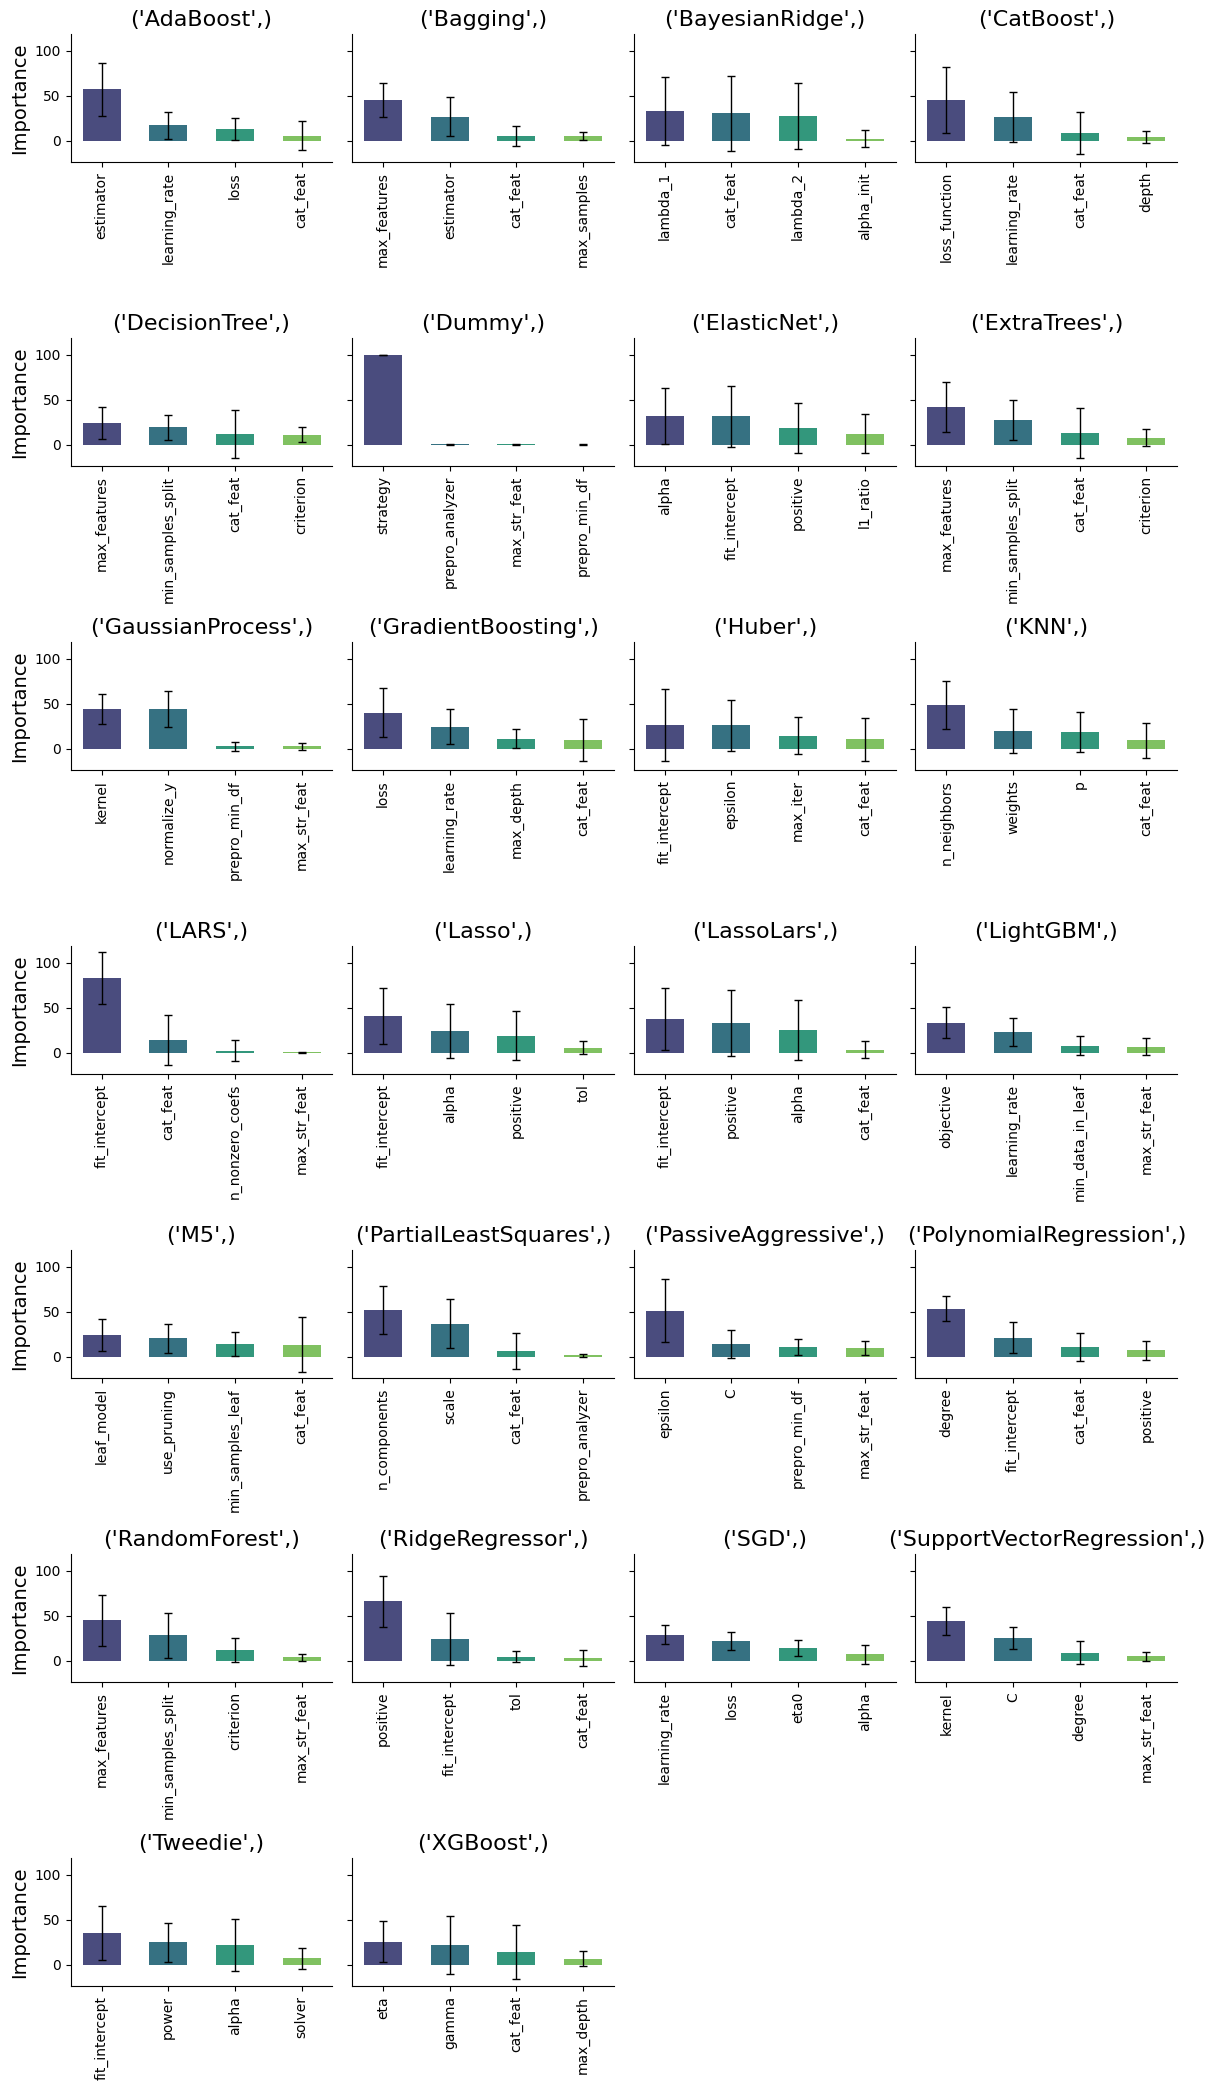

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def abreviate(feat):
    abreviations = {
        "enable_categorical_features": "cat_feat",
        "prepro_max_features": "max_str_feat",
    }
    return abreviations.get(feat, feat)

def plot_feature_importances_vertical(models_dict, n=4):
    rows = []
    for model, feats in models_dict.items():
        for feat, vals in feats.items():
            vals = np.asarray(vals, float)
            rows.append({
                "model": model,
                "feature": abreviate(feat),
                "mean": vals[0],
                "var": vals[1]
            })

    df = pd.DataFrame(rows)

    # df = df[df["mean"] > 1]

    top = (
        df.sort_values(["model", "mean"], ascending=[True, False])
          .groupby("model")
          .head(n)
    )
    print(top)

    g = sns.FacetGrid(top, col="model", col_wrap=4, sharex=False, sharey=True)
    g.map_dataframe(
        sns.barplot,
        x="feature",
        y="mean",
        errorbar=None,
        palette="viridis",
        width=0.3,
        gap=-0.9
    )

    # Add error bars manually
    for ax, (_, subdf) in zip(g.axes.flat, top.groupby("model")):
        ax.errorbar(
            subdf["feature"],
            subdf["mean"],
            yerr=np.sqrt(subdf["var"]),
            fmt="none",
            ecolor="black",
            capsize=3,
            linewidth=1
        )
        ax.set_xlabel("", fontsize=font_size)
        ax.set_ylabel("Importance", fontsize=font_size)
        ax.tick_params(axis='x', rotation=90)
        

    g.set_titles("{col_name}", size=font_size_large)
        
    plt.tight_layout()
    plt.show()

plot_feature_importances_vertical(results)

In [53]:
results[("AdaBoost",)]

{'allow_nans': [0.29491302860035723, 0.17904359414881074],
 'enable_categorical_features': [5.487983335751074, 252.95832156025807],
 'enable_datetime_features': [0.31621487935538306, 0.6003307398955213],
 'enable_raw_text_features': [0.2989545893641427, 0.22951154150806438],
 'enable_text_ngram_features': [0.2569653372348472, 0.050528079519457855],
 'enable_text_special_features': [0.3817451898623313, 0.1853213125140954],
 'estimator': [57.01099678343577, 887.4983390715693],
 'learning_rate': [16.868240154894607, 211.032167097371],
 'loss': [13.027623721708315, 142.04758727524268],
 'prepro_analyzer': [1.4532070915361732, 2.226766394623826],
 'prepro_max_features': [2.3265004419576223, 6.466855068597061],
 'prepro_min_df': [2.2766554462993747, 5.3103515876502545]}

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

RecursionError: maximum recursion depth exceeded while calling a Python object